Acknowledgement: This code was adapted from an LDA tutorial. This tutorial can be found at the following link: https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction import text 
from spacy.tokenizer import Tokenizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from spacy.lang.en import English
from collections import Counter
from string import punctuation
from nltk import word_tokenize
import pandas as pd
import altair as alt
import numpy as np
import gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import Phrases
from gensim.models.phrases import Phraser
import matplotlib.pyplot as plt
import nltk
import re

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
# 0. Set up allegations data from csv #
#
# read in csv
narratives_csv_url = "https://raw.githubusercontent.com/andresnigenda/cpd_complaints_nlp/andres/narratives.csv"
df = pd.read_csv(narratives_csv_url)
# filter to relevant section
df = df[df.column_name == "Initial / Intake Allegation"]

#Check if we duplicates are due to different variation in columns other than cr_id and text
df.drop(columns=['pdf_name','doccloud_url','dropbox_path','page_num'], inplace=True)
filtered_df = df.drop_duplicates().reset_index()
print("There are {} complaints after dropping columns".format(filtered_df.shape[0]))
print(filtered_df)
#Looks like most of the duplicates come from the other columns so we want to keep rows with unique content for cr_id and text
# filter to relevant columns
df = df[['cr_id', 'text']]
print("There are {} complaints".format(df.shape[0]))
# drop allegations with same id + text
df = df.drop_duplicates(['cr_id', 'text'])
print("There are {} unique complaints".format(df.shape[0]))
#allegations_lst = df['text'].to_list()
df.head()

There are 17059 complaints after dropping columns
       index  ...  batch_id
0          0  ...         1
1          4  ...         1
2          9  ...         1
3         12  ...         1
4         14  ...         1
...      ...  ...       ...
17054  30703  ...         5
17055  30706  ...         5
17056  30707  ...         5
17057  30711  ...         5
17058  30715  ...         5

[17059 rows x 6 columns]
There are 19966 complaints
There are 17001 unique complaints


,cr_id,text
0,1048960,The reporting party alleges that the\naccused ...
4,1048962,The victim alleges that an unknown male\nblack...
9,1048964,The reporting party alleges that he was a\nvi...
12,1048965,The reporting party alleges that while\nwaitin...
14,1048965,The reporting party alleges that while\nwaitin...


In [0]:
from sklearn.metrics.pairwise import cosine_similarity

def cosine_sim_vectors(vec1, vec2):
  vec1 = vec1.reshape(1,-1)
  vec2 = vec2.reshape(1,-1)
  return cosine_similarity(vec1, vec2)[0][0]

def split_half_and_compare(str_input):
  if len(str_input) < 2 or str_input in ['nfi', 'NFI'] or str_input in nltk.corpus.stopwords.words('english'):
    return False
  first_half = str_input[0:len(str_input)//2] 
  second_half = str_input[len(str_input)//2 if len(str_input)%2 == 0
                                 else ((len(str_input)//2)+1):]
  #print(first_half)
  #print(second_half)
  vectorizer = CountVectorizer().fit_transform([first_half, second_half])
  vectors = vectorizer.toarray()
  similarity_score = cosine_sim_vectors(vectors[0], vectors[1])
  #print(similarity_score)
  return similarity_score > .9

In [0]:
df['DuplicateText'] = df['text'].apply(split_half_and_compare)
duplicated_df = df[df['DuplicateText'] == True].reset_index()
df['text'] = df.apply(lambda row: row['text'] if row['DuplicateText'] == False else row['text'][0:len(row['text'])//2], axis=1)

In [0]:
def convert_to_words(sentences):
    for sent in sentences:
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
df_sentences = df.text.values.tolist()
df_words = list(convert_to_words(df_sentences))
#Check the first 2 sentences
print(df_words[:2])

[['the', 'reporting', 'party', 'alleges', 'that', 'the', 'accused', 'officer', 'was', 'rude', 'and', 'unprofessional', 'during', 'traffic', 'stop', 'the', 'accused', 'officer', 'threatened', 'to', 'place', 'her', 'in', 'handcuffs', 'and', 'failed', 'to', 'inform', 'the', 'complainant', 'as', 'to', 'why', 'she', 'was', 'being', 'stopped', 'the', 'reporting', 'party', 'further', 'alleges', 'that', 'the', 'officer', 'stated', 'license', 'and', 'registration', 'now', 'before', 'snatch', 'you', 'out', 'of', 'this', 'car', 'and', 'put', 'you', 'in', 'handcuffs'], ['the', 'victim', 'alleges', 'that', 'an', 'unknown', 'male', 'black', 'off', 'duty', 'officer', 'threw', 'her', 'against', 'the', 'wall', 'after', 'she', 'did', 'not', 'adhere', 'to', 'his', 'command', 'to', 'get', 'up', 'the', 'victim', 'alleges', 'that', 'the', 'officer', 'pushed', 'her', 'face', 'against', 'the', 'wall', 'and', 'handcuffed', 'her', 'too', 'tightly']]


In [0]:
#Construct the list of stop words that contains common English stop words
#and specific stop words from data
from nltk.corpus import stopwords
STOP_WORDS = stopwords.words('english')
additional_stopwords = list(set(["accused", "reporting", "party", "alleges", "officer", 
                        "alleged", "alleges", "complainant", "officers", "victim", 
                        "police", "stated", "report", "states", "called", 
                        "did", "told", "provide", "incident", "regarding", "issued",
                        "reported", "vehicle", "car", "justification",
                        "district", "uniformed", "threatened", "witness", "th",
                        "number", "scene"]))
STOP_WORDS.extend(additional_stopwords)

In [0]:
# Build the bigram and trigram models
bigram = Phrases(df_words, min_count=5, threshold=100)
trigram = Phrases(bigram[df_words], threshold=100)  
bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once

def remove_stopwords(texts):
    '''
    Loop through each document and use simple_preprocess() to convert each document
    Then loop through each word in the document and remove stop words
    Return a list of list of words 
    '''
    return [[word for word in simple_preprocess(str(doc)) if word not in STOP_WORDS] for doc in texts]    

def process_words(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """
    Remove Stopwords, Form Bigrams, Trigrams and Lemmatization
    https://spacy.io/api/annotation
    """
    texts = remove_stopwords(texts)
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    
    texts_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = remove_stopwords(texts_out)   
    return texts_out

lemmatized_data = process_words(df_words)

Generate data visualizations to evaluate model results

In [0]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

def generate_word_cloud(model, num_topics):
  cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

  cloud = WordCloud(stopwords=STOP_WORDS,
                    background_color='white',
                    width=2500,
                    height=1800,
                    max_words=20,
                    colormap='tab10',
                    color_func=lambda *args, **kwargs: cols[i],
                    prefer_horizontal=1.0)

  topics = model.show_topics(formatted=False)

  fig, axes = plt.subplots(int(num_topics/2), 2, figsize=(15,15), sharex=True, sharey=True)

  for i, ax in enumerate(axes.flatten()):
      fig.add_subplot(ax)
      topic_words = dict(topics[i][1])
      cloud.generate_from_frequencies(topic_words, max_font_size=300)
      plt.gca().imshow(cloud)
      plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
      plt.gca().axis('off')


  plt.subplots_adjust(wspace=0, hspace=0)
  plt.axis('off')
  plt.margins(x=0, y=0)
  plt.tight_layout()
  plt.show()

Create a function to display dominant topic for each document

In [0]:
def get_topics_df(lda_model, corpus, texts):
    #initialize an empty dataframe
    topics_df = pd.DataFrame()

    # Get main topic in each document
    for _, row_list in enumerate(lda_model[corpus]):
        row = row_list
        if lda_model.per_word_topics:
          row = row_list[0]      
        # each row contains a list of tuple with topic number and percent contribution of each keyword 
        # sort the tuple (topic number, keywords) in a row by percent contribution
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        
        # Get the the dominant topic, percent contribution and list of keywords for each document
        #first element is the dominant topic with highest contribution percent
        (dominant_topic_num, dominant_topic_prop) = row[0]
        
        #lda_model.show_topic() returns a list of tuples (keyword, percent contribution)
        topic_keyword_pct_list = lda_model.show_topic(dominant_topic_num)
        topic_keywords = ", ".join([word for word, _ in topic_keyword_pct_list])
        
        #add to the df
        topics_df = topics_df.append(pd.Series([int(dominant_topic_num), 
                                                round(dominant_topic_prop,2), 
                                                topic_keywords]), 
                                     ignore_index=True)
    # Add original text to the end of the output
    original_text = pd.Series(texts)
    topics_df = pd.concat([topics_df, original_text], axis=1)
    return topics_df

In [0]:
from matplotlib.ticker import FuncFormatter

# Dominant Topics in Each Document
def get_doc_cnt_per_topic(dominant_topic_df):
  dominant_topic = dominant_topic_df[['Document_Number', 'Dominant_Topic']]
  doc_cnt_per_topic = dominant_topic.groupby('Dominant_Topic').size()
  doc_cnt_per_topic = doc_cnt_per_topic.to_frame(name='count').reset_index()
  return doc_cnt_per_topic

def bar_chart_doc_by_topic(model, doc_cnt_per_topic):
  # Plot
  fig, ax = plt.subplots(figsize=(12, 8))

  # Number of Documents by Dominant Topics
  ax.bar(x='Dominant_Topic', height='count', data=doc_cnt_per_topic, width=.5, color='purple')
  ax.set_xticks(range(doc_cnt_per_topic.Dominant_Topic.unique().__len__()))
  #tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
  #plt.xaxis.set_major_formatter(tick_formatter)
  ax.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=20))
  ax.set_xlabel('Topic', fontsize=15)
  ax.set_ylabel('Number of Documents', fontsize=15)
  ax.set_ylim(0, 4000)

  plt.show()

def get_topic_words(dominant_topic_df):
  topic_words = dominant_topic_df[['Dominant_Topic', 'Keywords']]
  topic_words.drop_duplicates(inplace=True)
  topic_words.sort_values(by='Dominant_Topic', ascending=True, inplace=True)
  return topic_words

In [0]:
!pip install pyLDAvis

In [0]:
#import pyLDAvis.gensim

#We should call this for the best model only
#pyLDAvis.enable_notebook()
#vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
#vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.353371  0.067640       1        1  13.574898
7      0.116888 -0.041281       2        1  12.193153
5      0.114175  0.416257       3        1  11.245929
2     -0.208421 -0.018745       4        1  11.039698
8      0.061297 -0.048676       5        1  10.969457
9      0.061782 -0.053441       6        1   9.211851
3      0.042942 -0.100473       7        1   8.741918
1      0.059388 -0.081109       8        1   8.427420
0      0.040218 -0.073812       9        1   8.175740
4      0.065100 -0.066362      10        1   6.419944, topic_info=           Term         Freq        Total Category  logprob  loglift
0          fail  5089.000000  5089.000000  Default  30.0000  30.0000
79       arrest  4201.000000  4201.000000  Default  29.0000  29.0000
78       search  3133.000000  3133.000000  Default  28.0000  28.0000
16         male  2405.000000  2405.000000  Default  27.0000  27.0000
9          stop  2065.000000  2065.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
731       entry    96.463654    97.708664  Topic10  -4.9061   2.7329
307     message    94.658615    95.903709  Topic10  -4.9250   2.7327
475        girl    97.874428    99.195854  Topic10  -4.8916   2.7323
1170  impounded   116.424263   118.062195  Topic10  -4.7181   2.7318
892      escape   163.338013   167.705872  Topic10  -4.3795   2.7194

[337 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
364       6  0.997557    accident
755       9  0.994876      action
3418      7  0.993971  afterwards
275       5  0.997982       allow
911       3  0.993224      almost
...     ...       ...         ...
466      10  0.994865        word
163       4  0.997133       would
1719      7  0.994691        yard
666       2  0.996194        year
229       9  0.994690        yell

[317 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 8, 6, 3, 9, 10, 4, 2, 1, 5])

In [0]:
import pyLDAvis.gensim
import warnings
warnings.filterwarnings('ignore')

#Build the model and evaluate
def build_and_evaluate(data_input, num_topics):
  print("Number of topics: {}".format(num_topics))
  # Create Dictionary
  id2word = corpora.Dictionary(lemmatized_data)

  # Create Corpus: Term Document Frequency
  corpus = [id2word.doc2bow(text) for text in lemmatized_data]

  # Build LDA model
  lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                              id2word=id2word,
                                              num_topics=num_topics, 
                                              random_state=100,
                                              update_every=1,
                                              chunksize=10,
                                              passes=10,
                                              alpha='symmetric',
                                              iterations=100,
                                              per_word_topics=True)
  print("Printing topics....")
  print(lda_model.print_topics())

  dominant_topic_df = get_topics_df(lda_model, corpus, lemmatized_data).reset_index()
  dominant_topic_df.columns = ['Document_Number', 'Dominant_Topic', 'Topic_Contribution(%)', 'Keywords', 'Original_Text']
  print("Printing dominant topic dataframe....")
  print(dominant_topic_df.head(20))

  print("")
  print("Data Visualization....")
  generate_word_cloud(lda_model, num_topics)

  doc_cnt_per_topic = get_doc_cnt_per_topic(dominant_topic_df)
  bar_chart_doc_by_topic(lda_model, doc_cnt_per_topic)
  topic_words = get_topic_words(dominant_topic_df)
  print(topic_words)

Number of topics: 2
Printing topics....
[(0, '0.053*"arrest" + 0.053*"fail" + 0.016*"return" + 0.015*"falsely" + 0.015*"refuse" + 0.013*"call" + 0.013*"respond" + 0.011*"inventory" + 0.010*"time" + 0.009*"go"'), (1, '0.039*"search" + 0.023*"male" + 0.018*"stop" + 0.017*"citation" + 0.014*"residence" + 0.012*"time" + 0.012*"traffic" + 0.011*"also" + 0.011*"warrant" + 0.010*"unknown"')]
Printing dominant topic dataframe....
    Document_Number  ...                                      Original_Text
0                 0  ...  [rude, unprofessional, traffic, stop, place, h...
1                 1  ...  [unknown, male, black, duty, throw, get, push,...
2                 2  ...  [battery, arrive, fail, file, behalf, instead,...
3                 3  ...  [wait, unknown, female, exit, identified, dete...
4                 4  ...  [wait, unknown, female, exit, identified, dete...
5                 5  ...  [telephone, recovery, steal, respond, never, t...
6                 6  ...  [telephone, reco

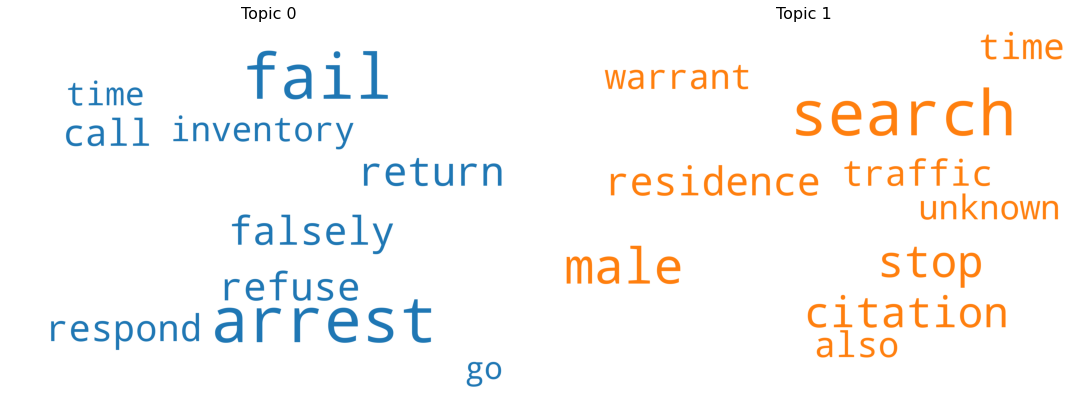

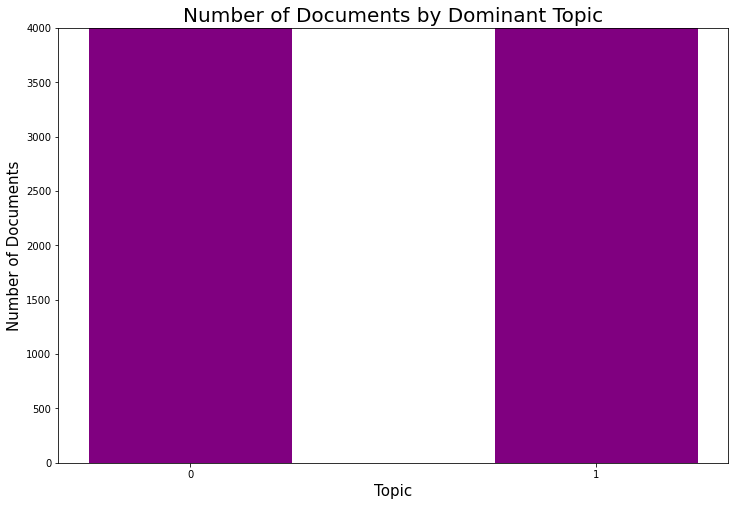

   Dominant_Topic                                           Keywords
2             0.0  arrest, fail, return, falsely, refuse, call, r...
0             1.0  search, male, stop, citation, residence, time,...
Number of topics: 4
Printing topics....
[(0, '0.038*"go" + 0.037*"citation" + 0.023*"place" + 0.020*"property" + 0.019*"several" + 0.018*"station" + 0.017*"leave" + 0.015*"false" + 0.014*"identify" + 0.014*"gun"'), (1, '0.082*"arrest" + 0.081*"fail" + 0.036*"male" + 0.026*"unknown" + 0.024*"return" + 0.023*"falsely" + 0.018*"subject" + 0.017*"respond" + 0.017*"refuse" + 0.017*"inventory"'), (2, '0.074*"search" + 0.029*"residence" + 0.026*"also" + 0.025*"take" + 0.025*"time" + 0.025*"call" + 0.021*"warrant" + 0.019*"drive" + 0.017*"drug" + 0.017*"question"'), (3, '0.050*"stop" + 0.032*"traffic" + 0.024*"phone" + 0.024*"case" + 0.020*"inform" + 0.020*"rude" + 0.019*"order" + 0.019*"driver" + 0.017*"license" + 0.016*"inventorie"')]
Printing dominant topic dataframe....
    Document_Num

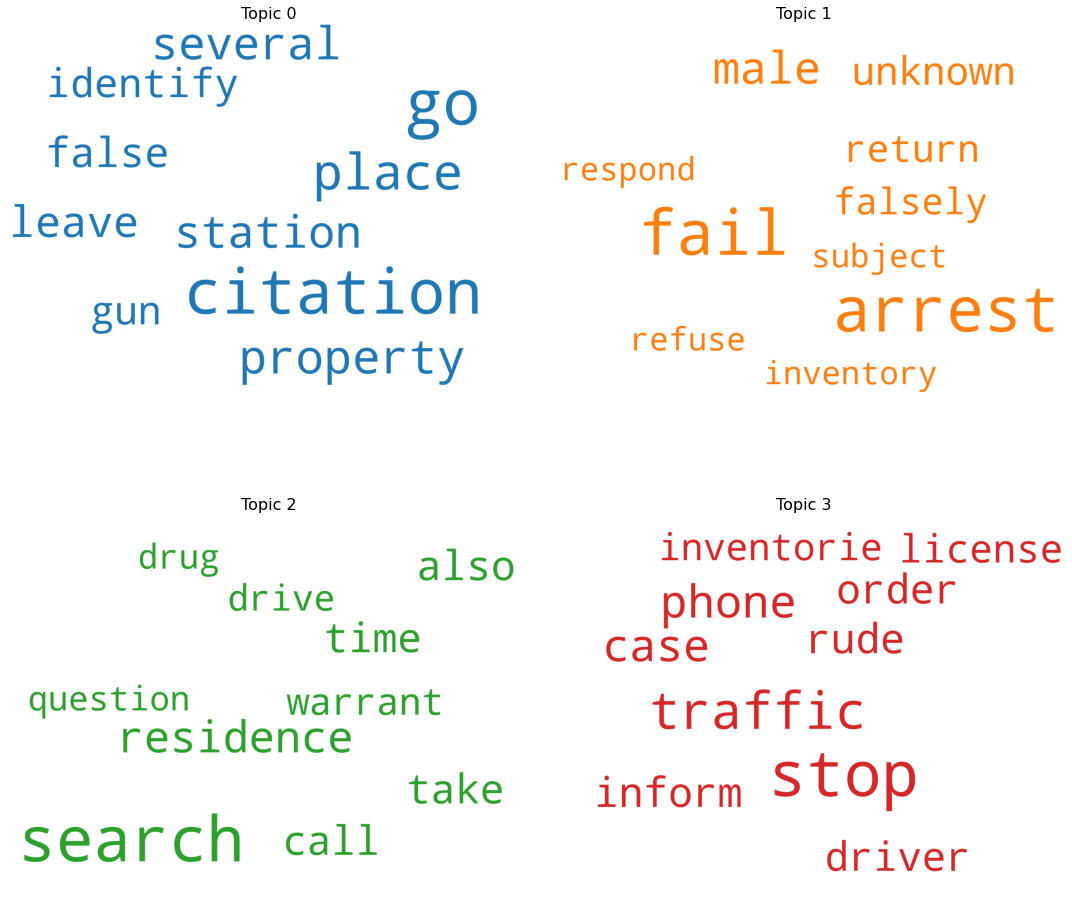

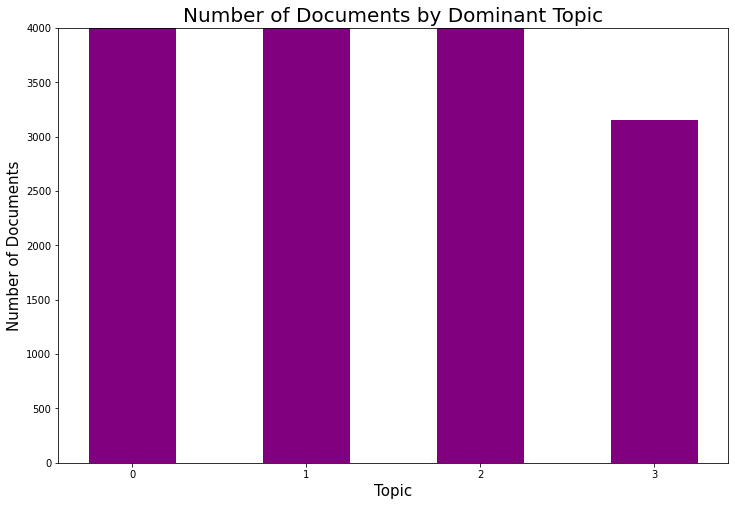

   Dominant_Topic                                           Keywords
7             0.0  go, citation, place, property, several, statio...
1             1.0  arrest, fail, male, unknown, return, falsely, ...
5             2.0  search, residence, also, take, time, call, war...
0             3.0  stop, traffic, phone, case, inform, rude, orde...


In [0]:
for num_topics in [2,4]:
  build_and_evaluate(lemmatized_data, num_topics)